In [ ]:
import pandas as pd
import gdown

# Đường link chia sẻ Google Drive
file_id = "1y37eCqZeKQuoYidj_dr1oGMjq3yTmiYm"

# Tạo URL trực tiếp đến tệp dữ liệu
url = f"https://drive.google.com/uc?id={file_id}"

# Đường dẫn để lưu trữ tệp đã tải xuống
output = 'data hashtag book.csv'

# Tải xuống và lưu trữ tệp
gdown.download(url, output, quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1y37eCqZeKQuoYidj_dr1oGMjq3yTmiYm
To: /content/data hashtag book.csv
100%|██████████| 8.28M/8.28M [00:00<00:00, 24.7MB/s]


'data hashtag book.csv'

In [ ]:
!pip install transformers
!pip install nltk
!pip install torch

In [ ]:
data = pd.read_csv("data hashtag book.csv")

# Outline
- <a href = #link1>  1. Data Overview </a>

# <a name='link1'>  1. Data Overview</a>

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
import nltk
import pandas as pd
import numpy as np
import os
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from nltk.corpus import stopwords
from nltk.util import ngrams

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import classification_report,confusion_matrix

from collections import defaultdict
from collections import Counter
plt.style.use('ggplot')

import re
from nltk.tokenize import word_tokenize
import gensim
import string

from tqdm import tqdm
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Embedding, LSTM,Dense, SpatialDropout1D, Dropout
from keras.initializers import Constant
from keras.optimizers import Adam

import warnings
warnings.simplefilter('ignore')

# CHúng ta tổng quan về data

In [ ]:
data.head()

,Unnamed: 0,Title,Description,Topic
0,0,The Devil's Disciple,Set in Colonial America during the Revolutiona...,Drama War History Fiction and Literature
1,1,Taking Chances,Spice-o-meter Rating: This fun romance is a so...,Romance
2,2,Verdi : The Story of the Little Boy who Loved ...,This time Tapper moves his focus to Italy in h...,Music Biography
3,3,Success,The contents of this volume originally appeare...,Non-fiction Business
4,4,Triplanetary,"ONE MAN DISCOVERED THE TRUTH—The Fall of Rome,...",Science Fiction Post-1930 Fiction and Literature


In [ ]:
data = data.drop(["Unnamed: 0"], axis = 1)

In [ ]:
len(data)

18100

In [ ]:
data

,Title,Description,Topic
0,The Devil's Disciple,Set in Colonial America during the Revolutiona...,Drama War History Fiction and Literature
1,Taking Chances,Spice-o-meter Rating: This fun romance is a so...,Romance
2,Verdi : The Story of the Little Boy who Loved ...,This time Tapper moves his focus to Italy in h...,Music Biography
3,Success,The contents of this volume originally appeare...,Non-fiction Business
4,Triplanetary,"ONE MAN DISCOVERED THE TRUTH—The Fall of Rome,...",Science Fiction Post-1930 Fiction and Literature
...,...,...,...
18095,Journey to the East,This book tells the tale of a man who goes on ...,Adventure stories
18096,The Monk Who Sold His Ferrari: A Fable About F...,"Wisdom to Create a Life of Passion, Purpose, a...",Health & Fitness
18097,I Am that,This collection of the timeless teachings of o...,Philosophy
18098,The Berlin Phenomenology,Since the three volume edition ofHegel's Philo...,History


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18100 entries, 0 to 18099
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Title        18100 non-null  object
 1   Description  18100 non-null  object
 2   Topic        18100 non-null  object
dtypes: object(3)
memory usage: 424.3+ KB


# Dữ liệu gồm có các cột Title, Desciption và Topic avf gồm có 6179 dòng dữ liệu cần làm việc và không có dòng dữ liệu nào bị thiếu
# Các biến độc lập là title và Description và biến phụ thuộc và Topic

# <a name='link2'>  2. EDA</a>

In [ ]:
topic_counts = data["Topic"].value_counts()

print((topic_counts))
print(len(topic_counts))

Topic
Fiction                              6209
others                               1255
Biography & Autobiography            1049
Fiction Classics                      778
History                               700
                                     ... 
Economics (Academic)                   10
Medical (Academic)                     10
Computers Post-1930 Instructional      10
Instructional Nature Non-fiction       10
Architecture                           10
Name: count, Length: 107, dtype: int64
107


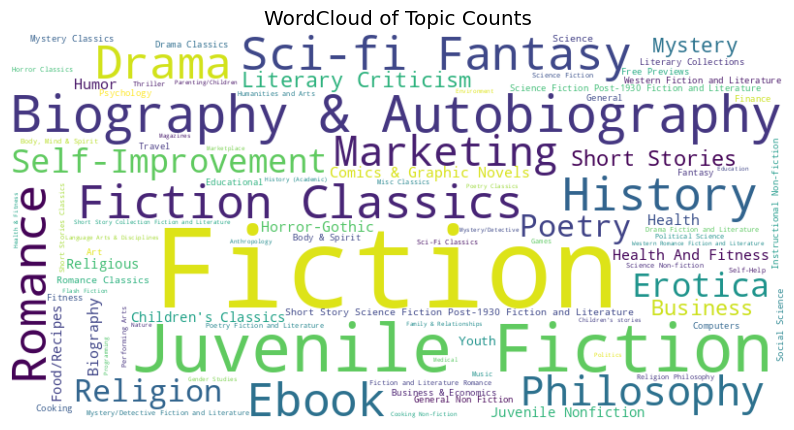

In [ ]:
from wordcloud import WordCloud

# Tạo WordCloud từ Series topic_counts
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(topic_counts)

# Hiển thị WordCloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('WordCloud of Topic Counts')
plt.axis('off')
plt.show()


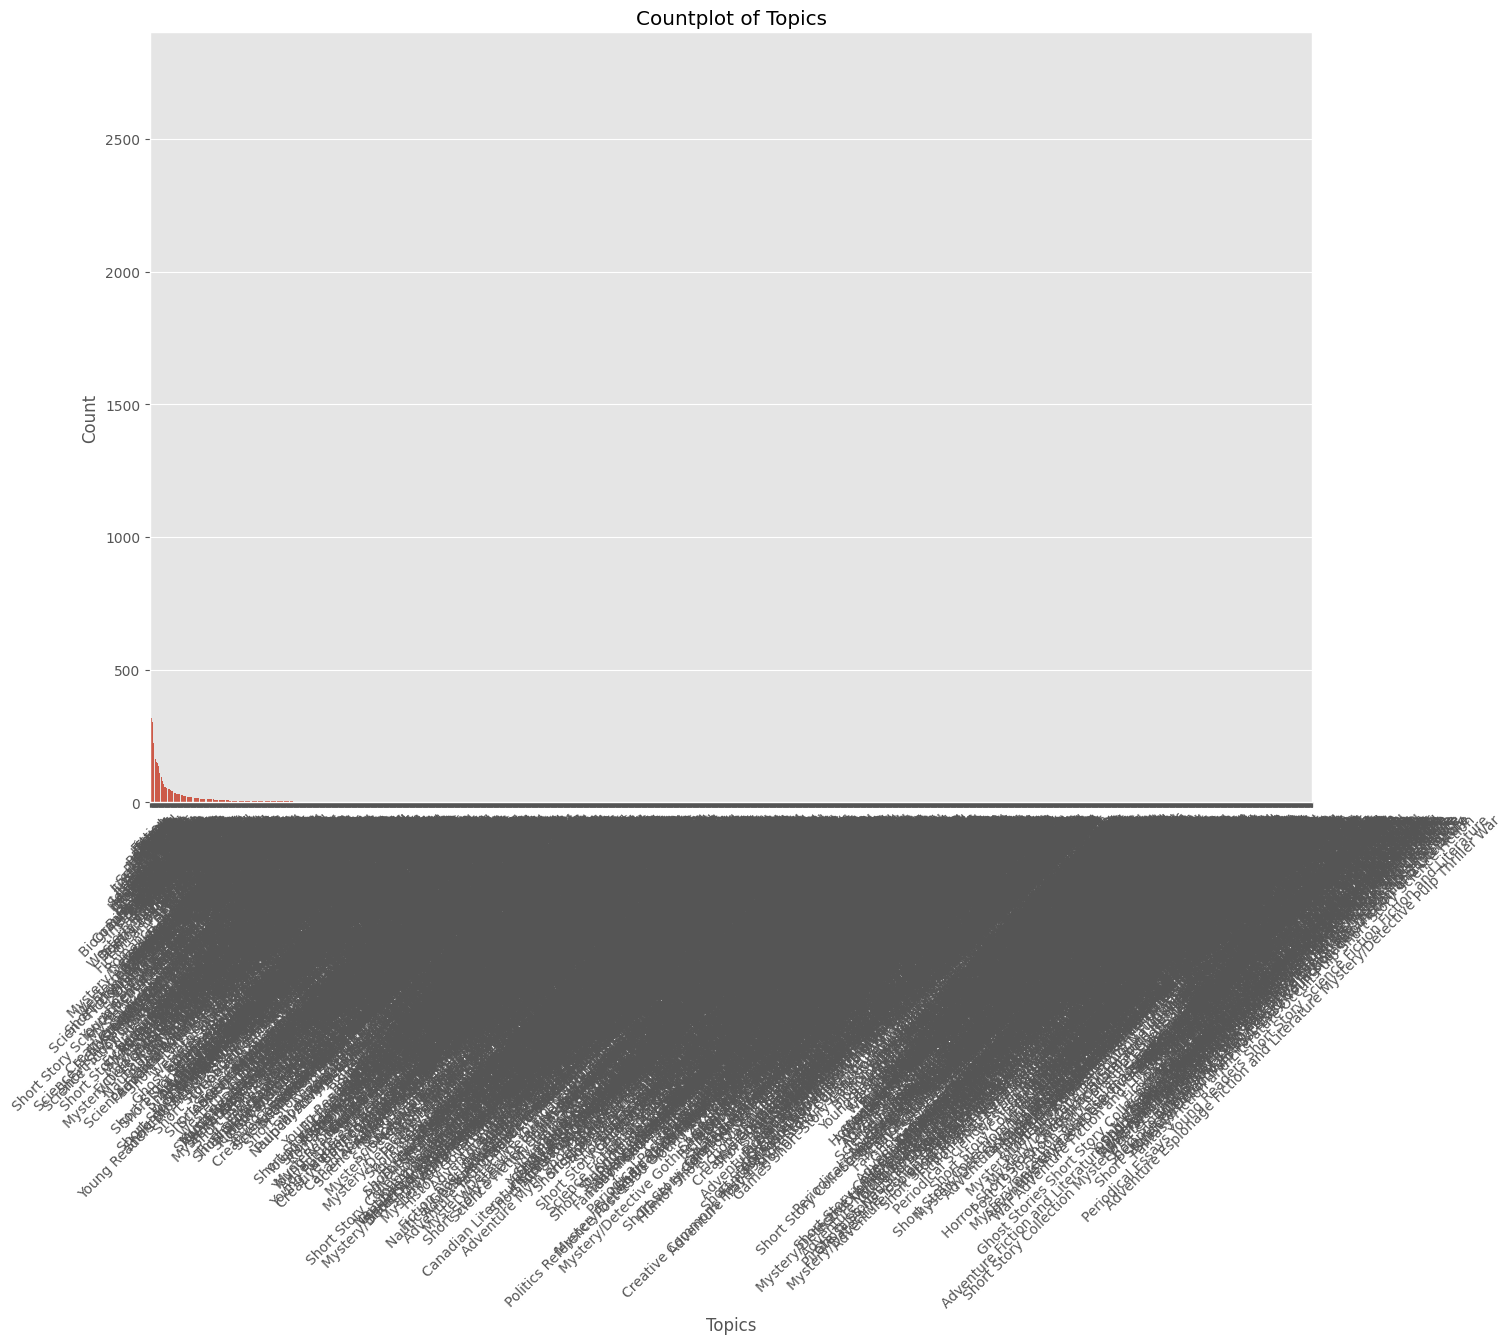

In [ ]:
topic_counts = data["Topic"].value_counts().sort_values(ascending=False)

# Tạo một figure mới với kích thước lớn
plt.figure(figsize=(15, 10))

# Vẽ countplot với dữ liệu đã sắp xếp
sns.countplot(data=data, x="Topic", order=topic_counts.index)
plt.title("Countplot of Topics")
plt.xlabel("Topics")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Xoay nhãn trục x để tránh trùng lắp
plt.show()

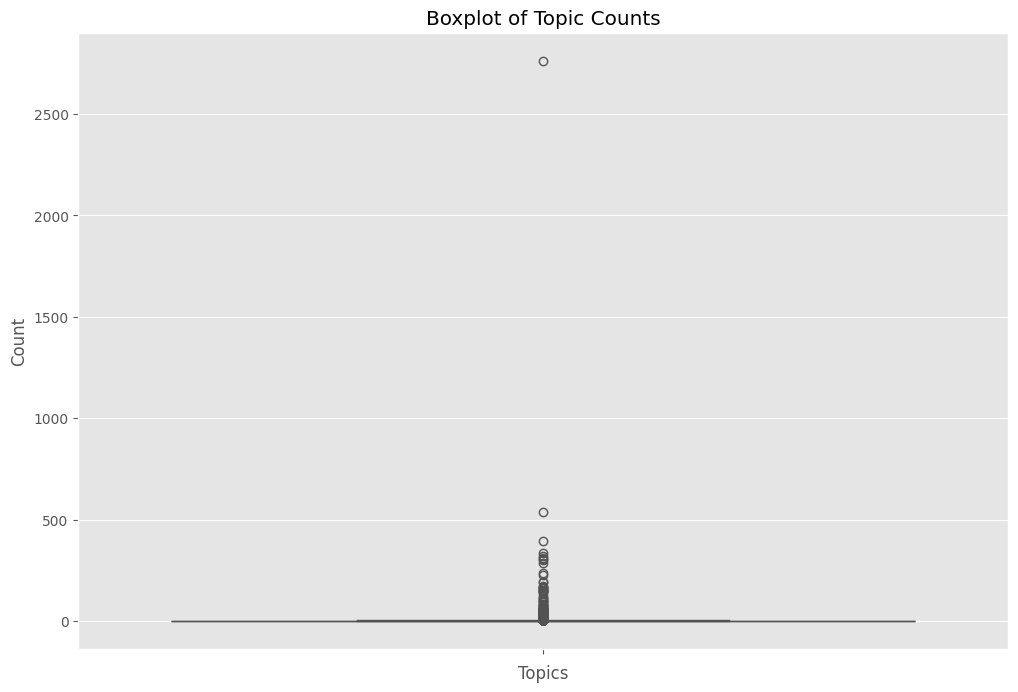

In [ ]:
topic_counts_df = topic_counts.reset_index()
topic_counts_df.columns = ['Topic', 'Count']

# Tạo boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(data=topic_counts_df, y="Count")
plt.title("Boxplot of Topic Counts")
plt.ylabel("Count")
plt.xlabel("Topics")
plt.xticks(rotation=45)  # Xoay nhãn trục x để tránh trùng lắp
plt.show()

In [ ]:
# Lọc các chủ đề có count dưới 100
topic_counts_under_100 = topic_counts_df[topic_counts_df['Count'] < 100]

# Đếm số lượng chủ đề có count dưới 100
num_topics_under_100 = len(topic_counts_under_100)

# Tính tổng số count của các chủ đề có count dưới 100
total_count_under_100 = topic_counts_under_100['Count'].sum()

print("Số lượng chủ đề có count dưới 100:", num_topics_under_100)
print("Tổng số count của các chủ đề có count dưới 100:", total_count_under_100)


Số lượng chủ đề có count dưới 100: 3278
Tổng số count của các chủ đề có count dưới 100: 9398


In [ ]:
# Lọc các chủ đề có count dưới 100
topic_counts_upper_100 = topic_counts_df[topic_counts_df['Count'] > 100]

# Đếm số lượng chủ đề có count dưới 100
num_topics_upper_100 = len(topic_counts_upper_100)

# Tính tổng số count của các chủ đề có count dưới 100
total_count_upper_100 = topic_counts_upper_100['Count'].sum()

print("Số lượng chủ đề có count lớn hơn 100:", num_topics_upper_100)
print("Tổng số count của các chủ đề có count dưới 100:", total_count_upper_100)


Số lượng chủ đề có count dưới 100: 29
Tổng số count của các chủ đề có count dưới 100: 8702


# <a name='link3'>  3. Data preprocessing </a>

# Loại bỏ các stopword

# Bước này gom các chủ đề tương tự như nhau

In [ ]:
# Tạo một dictionary để lưu các topic lớn hơn 100 và các topic nhỏ hơn 100 có liên quan đến chúng
related_topics = {}

# Lấy ra các topic có số lượng count lớn hơn 100
large_topics = data['Topic'].value_counts()[data['Topic'].value_counts() > 100].index

# Lấy các topic nhỏ hơn 100
small_topics = data['Topic'].value_counts()[data['Topic'].value_counts() <= 100].index

# Tìm kiếm các topic nhỏ hơn 100 có liên quan đến các topic lớn hơn 100 và đổi tên chúng
for small_topic in small_topics:
    for large_topic in large_topics:
        # Tách các từ trong chủ đề nhỏ hơn 100 và kiểm tra xem có từ nào xuất hiện trong chủ đề lớn hơn 100 không
        small_topic_words = set(small_topic.split())
        if any(word in small_topic_words for word in large_topic.split()):
            if large_topic in related_topics:
                related_topics[large_topic].append(small_topic)
            else:
                related_topics[large_topic] = [small_topic]

print(related_topics)


{'Fiction': ['Short Story Science Fiction Post-1930 Fiction and Literature', 'Western Fiction and Literature', 'General Non Fiction', 'Science Fiction Post-1930 Fiction and Literature', 'Mystery/Detective Fiction and Literature', 'Science Fiction', 'Drama Fiction and Literature', 'Poetry Fiction and Literature', 'Fiction and Literature Romance', 'Short Story Collection Fiction and Literature', 'Western Romance Fiction and Literature', 'Flash Fiction', 'Science Fiction Post-1930 Short Story Fiction and Literature', 'Fiction and Literature', 'Romance Fiction and Literature', 'Fiction and Literature Mystery/Detective', 'Science Fiction Short Story Post-1930 Fiction and Literature', 'Historical Fiction', 'Creative Commons Post-1930 Fiction and Literature', 'Young Readers Fantasy Fiction and Literature', 'Womens Fiction', 'Adventure Fiction and Literature', 'Language Fiction and Literature', 'Essays Fiction and Literature', 'Philosophy Fiction and Literature', 'Short Story Collection Fictio

In [ ]:
# Duyệt qua từng dòng trong data và thay thế các chủ đề nhỏ bằng chủ đề lớn tương ứng
for index, row in data.iterrows():
    topic = row['Topic']
    for large_topic, small_topics in related_topics.items():
        if topic in small_topics:
            data.at[index, 'Topic'] = large_topic
            break  # Đã thay thế chủ đề, không cần kiểm tra các chủ đề khác nữa



In [ ]:
# Lấy count từ cột 'Topic'
topic_counts = data['Topic'].value_counts()

# Lấy các chủ đề có count dưới 10
topics_below_10 = topic_counts[topic_counts < 10].index

# Gom các chủ đề có count dưới 10 thành chủ đề "others" trong biến data
data.loc[data['Topic'].isin(topics_below_10), 'Topic'] = 'others'


In [ ]:
topics_below_10

Index(['Periodical', 'Career', 'Science fiction', 'Self Teaching', 'Adventure',
       'Technology', 'Politics Essays Non-fiction', 'Pets', 'Americans',
       'Computers Post-1930 Non-fiction',
       ...
       'Young Readers Nautical Adventure Pirate Tales',
       'Correspondence Travel Essays',
       'Non-fiction Post-1930 Creative Commons', 'Non-fiction Periodical',
       'Reference Instructional', 'Reference Myth', 'Non-fiction Etiquette',
       'Periodical Nature Instructional', 'Reference Science Nature',
       'Indic fiction (English)'],
      dtype='object', name='Topic', length=795)

In [ ]:
import pandas as pd

# Giả sử biến data là DataFrame của bạn có cột 'topic'

# Tạo các khoảng giá trị dựa trên số lượng dữ liệu trong cột 'topic'
bins = [0, 50, 100, 1000, float('inf')]  # Định nghĩa các khoảng giá trị
labels = ['nhóm 1', 'nhóm 2', 'nhóm 3', 'nhóm 4']  # Nhãn cho các nhóm

# Tạo một dictionary để lưu các topic vào các nhóm
topic_groups = {label: [] for label in labels}

# Duyệt qua từng topic và phân loại vào các nhóm tương ứng
for topic, count in data['Topic'].value_counts().items():
    if count <= 50:
        topic_groups['nhóm 1'].append(topic)
    elif count <= 100:
        topic_groups['nhóm 2'].append(topic)
    elif count <= 1000:
        topic_groups['nhóm 3'].append(topic)
    else:
        topic_groups['nhóm 4'].append(topic)

# In ra số lượng topic trong mỗi nhóm
for label, topics in topic_groups.items():
    print(f"{label}: {len(topics)}")

# In ra các topic trong mỗi nhóm
for label, topics in topic_groups.items():
    print(f"{label}: {topics}")


nhóm 1: 64
nhóm 2: 13
nhóm 3: 27
nhóm 4: 3
nhóm 1: ['Performing Arts', 'Humanities and Arts', 'Games', 'Music', 'Thriller', 'Science Non-fiction', 'Political Science', 'Self-Help', 'Gender Studies', 'Environment', 'Anthropology', 'Nature', 'Cooking Non-fiction', 'Programming', 'Politics', 'Magazines', 'Mystery/Detective', 'Education', 'Marketplace', 'Medical', 'Parenting/Children', 'International', 'Insurance', 'Horror', 'Adventure stories', 'Economy', 'Nature Non-fiction', 'Young Adult', 'Add a comment', 'Food and Drink', 'Childrens', 'Sequential Art', 'Books Published:', 'Reference', 'Default', 'English fiction', 'Physics', 'Academic Articles', 'Miscellaneous', 'Math', 'Law', 'Detective and mystery stories', 'Non-fiction', 'Science (Academic)', 'Sociology', 'Chemistry', 'American fiction', "Teacher's Resources", 'Mathematics', 'Tutorials', 'Politics Non-fiction', 'Biology', 'True Crime', 'Non-fiction Instructional', 'Foreign Language Study', 'Software', 'Science Textbooks', 'Photogra

In [ ]:
data['Topic'] = data['Topic'].replace(topic_groups['nhóm 1'], 'other_1')

# Gom các topic từ nhóm 2 thành "other 2"
data['Topic'] = data['Topic'].replace(topic_groups['nhóm 2'], 'other_2')

# In ra số lượng topic trong mỗi nhóm
print(data['Topic'].value_counts())

Topic
Fiction                      6209
other_1                      1385
others                       1255
Biography & Autobiography    1049
other_2                       874
Fiction Classics              778
History                       700
Juvenile Fiction              535
Sci-fi Fantasy                459
Philosophy                    437
Romance                       389
Short Stories                 302
Ebook                         301
Drama                         295
Health And Fitness            276
Literary Criticism            261
Marketing                     238
Religion                      206
Self-Improvement              192
Erotica                       191
Business                      185
Poetry                        175
Humor                         164
Comics & Graphic Novels       157
Mystery                       154
Biography                     148
Children's Classics           144
Health                        141
Horror-Gothic                 138
Juvenile

# Vẽ hình data

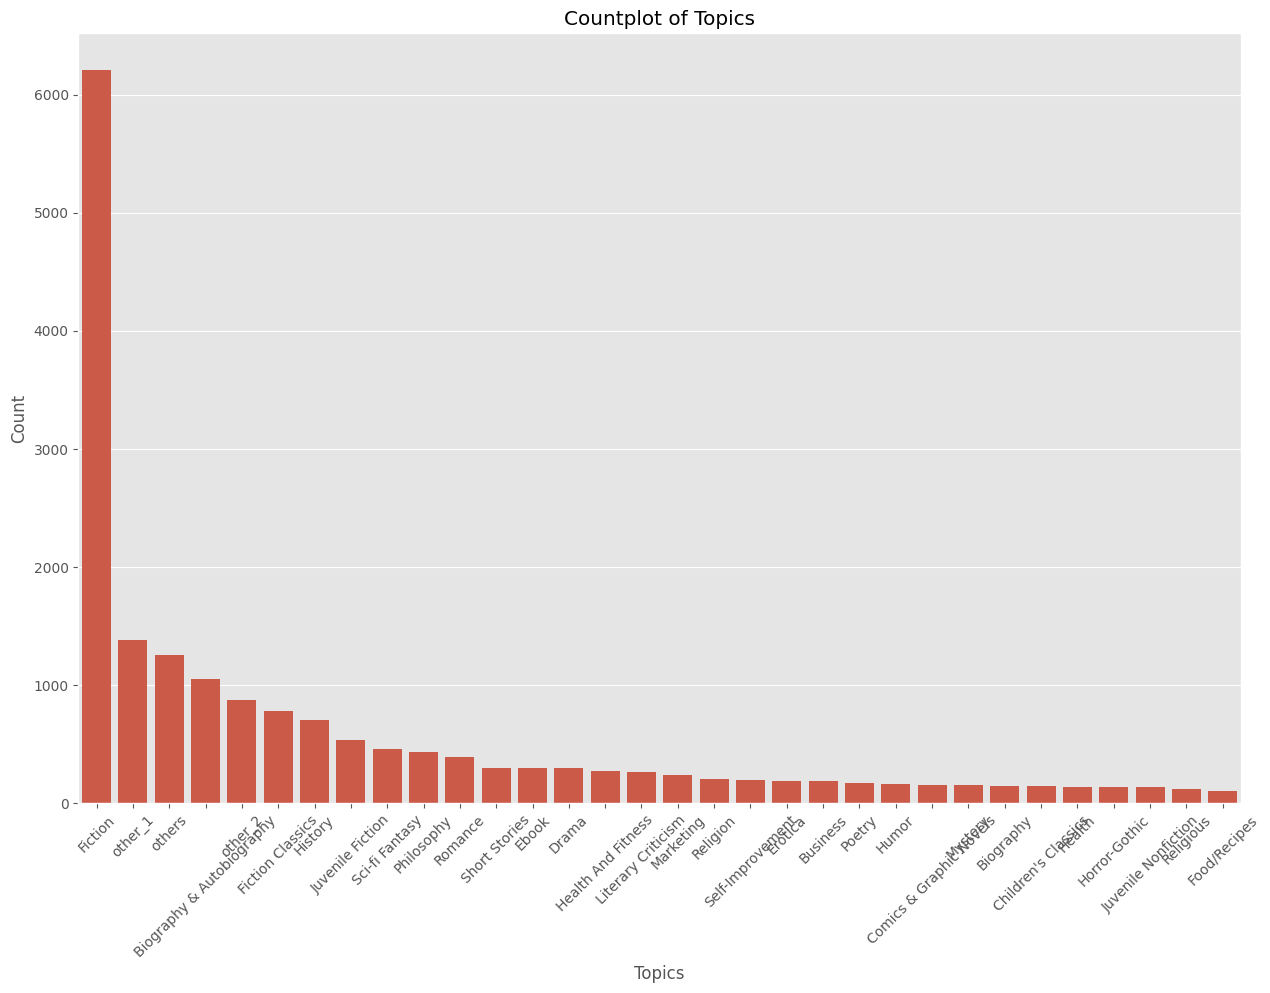

In [ ]:
topic_counts = data["Topic"].value_counts().sort_values(ascending=False)

# Tạo một figure mới với kích thước lớn
plt.figure(figsize=(15, 10))

# Vẽ countplot với dữ liệu đã sắp xếp
sns.countplot(data=data, x="Topic", order=topic_counts.index)
plt.title("Countplot of Topics")
plt.xlabel("Topics")
plt.ylabel("Count")
plt.xticks(rotation=45)  # Xoay nhãn trục x để tránh trùng lắp
plt.show()

# Sau khi giảm số lượng dữ liệu xuống

In [ ]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Tải danh sách stopwords tiếng Anh
stop_words = set(stopwords.words('english'))

# Văn bản mẫu
sample_text = "This is a sample sentence containing some stopwords."

# Tách từ trong văn bản mẫu
words = sample_text.split()

# Xóa stopwords từ văn bản mẫu
filtered_words = [word for word in words if word.lower() not in stop_words]

# In kết quả
print("Văn bản sau khi loại bỏ stopwords:")
print(' '.join(filtered_words))


Văn bản sau khi loại bỏ stopwords:
sample sentence containing stopwords.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Loại bỏ các dữ liệu không phù hợp cho việc train

In [ ]:
!pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 433.8/433.8 kB 5.2 MB/s eta 0:00:00


In [ ]:
data.to_csv("data train and test hashtag.csv")

In [ ]:
x import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')


def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.lower().split()  # Chuyển tất cả các từ thành chữ thường
    filtered_words = [word for word in words if word not in stop_words]
    return ' '.join(filtered_words)

import emoji

def remove_emoji(text):
    return emoji.demojize(text)

import re

def remove_dates(text):
    return re.sub(r'\b(?:\d{1,2}[/\-]\d{1,2}[/\-]\d{2,4}|\d{1,2}[/\-]\d{1,2})\b', '', text)

def remove_numbers_and_special_characters(text):
    return re.sub(r'[^a-zA-Z\s]', '', text)



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
stop_words = set(stopwords.words('english'))
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [ ]:

data['Descr'] = data['Description'].apply(remove_stopwords)
data['Descr'] = data['Description'].apply(remove_emoji)
data['Descr'] = data['Description'].apply(remove_dates)
data['Descr'] = data['Description'].apply(remove_numbers_and_special_characters)
data['Descr'] = data['Descr'].apply(remove_stopwords)


In [ ]:
data

,Title,Description,Topic,Descr
0,The Devil's Disciple,Set in Colonial America during the Revolutiona...,Fiction,set colonial america revolutionary era play te...
1,Taking Chances,Spice-o-meter Rating: This fun romance is a so...,Romance,spiceometer rating fun romance solid maybe sca...
2,Verdi : The Story of the Little Boy who Loved ...,This time Tapper moves his focus to Italy in h...,Biography & Autobiography,time tapper moves focus italy voyage among gre...
3,Success,The contents of this volume originally appeare...,Business,contents volume originally appeared weekly art...
4,Triplanetary,"ONE MAN DISCOVERED THE TRUTH—The Fall of Rome,...",Fiction,one man discovered truththe fall rome wars rac...
...,...,...,...,...
18095,Journey to the East,This book tells the tale of a man who goes on ...,other_1,book tells tale man goes wonderful amazing jou...
18096,The Monk Who Sold His Ferrari: A Fable About F...,"Wisdom to Create a Life of Passion, Purpose, a...",Biography & Autobiography,wisdom create life passion purpose peace inspi...
18097,I Am that,This collection of the timeless teachings of o...,Philosophy,collection timeless teachings one greatest sag...
18098,The Berlin Phenomenology,Since the three volume edition ofHegel's Philo...,History,since three volume edition ofhegels philosophy...


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.
